In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append(os.environ['DH_DIR'])

import numpy as np
import warnings

import darkhistory.physics as phys

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file('../matplotlibrc')

## 0. Utilities

In [2]:
year = 365.25 * 86400 # [s]

In [3]:
def unit_vec(v):
    return v / np.linalg.norm(v)

def rand_unit_3vec():
    return unit_vec(np.random.default_rng().normal(size=3))

def thph_to_3vec(th, ph):
    return np.array([np.sin(th)*np.cos(ph), np.sin(th)*np.sin(ph), np.cos(th)])

def lorentz_normsq(v): # [Mpc^2]
    return np.dot(v, v*np.array([-1, 1, 1, 1]))

def spatial_norm(v): # [Mpc^2]
    return np.sqrt(np.dot(v[1:], v[1:]))

def invert_4vec(u):
    return np.array([u[0], -u[1], -u[2], -u[3]])

def invar_normsq(v):
    return v[0]**2 - v[1]**2 - v[2]**2 - v[3]**2

def boost(v, boost_u):
    """Boost a 4-vector v in 4-velocity boost_u direction.
    (Take 4-velocity to have numerical stability for gamma.)"""
    g = boost_u[0]
    vx, vy, vz = boost_u[1:]/g
    vsq = vx**2 + vy**2 + vz**2
    B = np.array([
        [g,                 g*vx,              g*vy,              g*vz],
        [g*vx, 1+(g-1)*vx*vx/vsq,   (g-1)*vx*vy/vsq,   (g-1)*vx*vz/vsq],
        [g*vy,   (g-1)*vy*vx/vsq, 1+(g-1)*vy*vy/vsq,   (g-1)*vy*vz/vsq],
        [g*vz,   (g-1)*vz*vx/vsq,   (g-1)*vz*vy/vsq, 1+(g-1)*vz*vz/vsq]
    ])
    return np.dot(B, v)

def rotation_to(v):
    """Return the rotation matrix to get the z direction to v's direction."""
    x, y, z = v
    th = np.arctan2(np.sqrt(x**2+y**2), z) # y/x
    ph = np.arctan2(y, x)
    R1 = np.array([ # rotate counterclockwise by th around y axis
        [ np.cos(th), 0, np.sin(th)],
        [          0, 1,          0],
        [-np.sin(th), 0, np.cos(th)]
    ])
    R2 = np.array([
        [np.cos(ph), -np.sin(ph), 0],
        [np.sin(ph),  np.cos(ph), 0],
        [         0,           0, 1]
    ])
    return np.dot(R2, R1)

## 1. Particle class

In [4]:
class Particle:
    
    def __init__(self, m0=None, x=np.array([0, 0, 0, 0]), u=np.array([1, 0, 0, 0]), name=''):
        
        if not m0:
            raise ValueError('must set m0!')
        self.m0 = m0 # [eV]
        self.x = x # [t, x, y, z] | [Mpc]
        self.u = u # gamma * [1, vx, vy, vz] | 4-velocity
        self.name = name
        
        self.path = np.array([self.x])
        self.Ek_hist = np.array([self.Ek])
        self.stopped = False
        
    def init_with_Ek(self, Ek): # None([eV])
        
        gamma = (Ek + self.m0) / self.m0
        beta = np.sqrt(1-1/gamma**2)
        self.u = np.array([gamma, gamma*beta, 0, 0])
        
    @property
    def v(self):
        return self.u/self.u[0]
    @property
    def beta(self):
        return spatial_norm(self.v)
    @property
    def gamma(self):
        return self.u[0]
    @property
    def p(self):
        return self.m0 * self.u
    @property
    def E(self):
        return self.m0 * self.u[0]
    @property
    def Ek(self):
        return self.E - self.m0
        
        
    def travel_to_x(self, x, v=None): # None([Mpc] [1])
        last_x = self.x
        self.x = x
        if v:
            self.v = v
        self.path = np.append(self.path, [self.x], axis=0)
        self.Ek_hist = np.append(self.Ek_hist, [self.Ek], axis=0)
        if last_x[0] > x[0]:
            warnings.warn(f"particle '{self.name}' going back in time!")
        if lorentz_normsq(x-last_x) > 0:
            warnings.warn(f"particle '{self.name}' going faster than light!")
            
    def travel_for(self, t): # None([Mpc])
        self.travel_to_x(self.x + self.v*t)
        
    def distance(self): # [Mpc]()
        return spatial_norm(self.path[-1] - self.path[0])
    
    def distance_traveled(self): # [Mpc]()
        segments = self.path[1:] - self.path[:-1]
        return np.sum([spatial_norm(s) for s in segments])
    
    def stop(self):
        #self.v = np.array([1, 0, 0, 0])
        self.stopped = True

## 2. Processes classes

### 2.1 Sampling

In [5]:
from scipy import interpolate

In [6]:
class SamplerFromPDF:
    
    def __init__(self, pdf_func, x_edge):
        
        self.pdf_func = pdf_func
        self.x_edge = x_edge
        
        self.x_center = (x_edge[1:] + x_edge[:-1]) / 2
        self.x_width  =  x_edge[1:] - x_edge[:-1]
        self.cdf = np.cumsum(self.pdf_func(self.x_center) * self.x_width)
        self.cdf /= self.cdf[-1]
        
        # edges
        self.x_center = np.insert(self.x_center, 0, self.x_edge[0])
        self.cdf = np.insert(self.cdf, 0, 0.)
        self.x_center = np.append(self.x_center, self.x_edge[-1])
        self.cdf = np.append(self.cdf, 1.)
        
        self.invcdf_interp = interpolate.interp1d(self.cdf, self.x_center)
        
    def sample(self, n=1):
        return self.invcdf_interp(np.random.uniform(0, 1, size=(n,)))

In [7]:
def f_shell_BE_pdf(x):
    return x**2 / (np.exp(x) - 1)
x_edge_BE = np.concatenate([np.linspace(0, 5, 50, endpoint=False),
                            np.logspace(np.log10(5), np.log10(100), 50)])
BE_x_sampler = SamplerFromPDF(f_shell_BE_pdf, x_edge_BE)

def mu_out_pdf(mu):
    return 1 + mu**2
mu_edge = np.linspace(-1, 1, 100)
mu_out_sampler = SamplerFromPDF(mu_out_pdf, mu_edge)

In [8]:
def sample_CMB_p(TCMB):
    p_over_T = BE_x_sampler.sample()
    p = p_over_T * TCMB
    return np.insert(p*rand_unit_3vec(), 0, p)

### 2.2 Processes

In [9]:
class ComptonProcess:
    
    def total_rate(self, pt, rs, xHII=None): # [s^-1](Particle, [1], [1])
        return phys.thomson_xsec * phys.c * phys.CMB_N_density(phys.TCMB(rs))
    
    def engloss_rate(self, pt, rs, xHII=None): # [s^-1](Particle, [1], [1])
        return 4/3 * phys.CMB_eng_density(phys.TCMB(rs))*phys.c*phys.thomson_xsec * pt.beta**2 * pt.gamma**2/((pt.gamma-1)*phys.me)
    
    def process(self, pt, rs, max_n_scatter=500):
        # sample CMB photon
        p_in = sample_CMB_p(phys.TCMB(rs))
        # boost to electron frame
        p_in = boost(p_in, invert_4vec(pt.u))
        E_in = p_in[0]
        
        # sample mu_out and calculate p_out
        mu_out = mu_out_sampler.sample()
        E_out = E_in / (1 + E_in/phys.me * (1-mu_out))
        out_dir_th = np.arccos(mu_out)
        out_dir_ph = np.random.uniform(0, 2*np.pi)
        out_dir = thph_to_3vec(out_dir_th, out_dir_ph)
        in_dir = p_in[1:]
        out_dir = np.dot(rotation_to(in_dir), out_dir)
        p_out = np.insert(out_dir, 0, 1.) * E_out
        
        # new momentum
        k_out = np.array([pt.m0, 0, 0, 0]) + p_in - p_out
        
        # boost back to CMB frame
        k_out = boost(k_out, pt.u)
        
        if not np.isclose(invar_normsq(k_out), phys.me**2):
            k_out[0] = np.sqrt(phys.me**2 + np.dot(k_out[1:], k_out[1:]))
        pt.u = k_out / pt.m0
        
        # at certain energy, stop
        if len(pt.path) > max_n_scatter:
            pt.stop()

class CollisionHeatingProcess:
    
    def __init__(self, use_tcool_approx=False):
        self.use_tcool_approx = use_tcool_approx
    
    def total_rate(self, pt, rs, xHII=None): # [s^-1](Particle, [1], [1])
        Eek = pt.Ek
        xe = xHII if xHII else phys.xHII_std(rs) + phys.xHeII_std(rs)
        if self.use_tcool_approx:
            tcool = 5e3 * year * (1/xe) * (Eek/1e3)**(3/2) * (rs/10)**(-3)
            rate = 1 / tcool
        else:
            dEdt = phys.elec_heating_engloss_rate(Eek, xe, rs) # [eV/s]
            rate = dEdt / Eek # [1/s]
        return rate
    
    def engloss_rate(self, *args, **kwargs):
        return self.total_rate(*args, **kwargs)
    
    def process(self, pt, *args, **kwargs):
        pt.stop()

        
class IonizationProcess:
    
    def total_rate(self, pt, rs, xHII=None): # [s^-1](Particle, [1], [1])
        Eek = pt.Ek
        xHI = 1 - (xHII if xHII else phys.xHII_std(rs))
        tcool = 5e5 * year * (1/xHI) * (Eek/1e3)**(3/2) * (rs/10)**(-3)
        return 1/tcool
    
    def engloss_rate(self, *args, **kwargs):
        return self.total_rate(*args, **kwargs)
    
    def process(self, pt, *args, **kwargs):
        pt.stop()
        
        
class ExcitationProcess:
    
    def total_rate(self, pt, rs, xHII=None): # [s^-1](Particle, [1], [1])
        Eek = pt.Ek
        xHI = 1 - (xHII if xHII else phys.xHII_std(rs))
        tcool = 5e5 * year * (1/xHI) * (Eek/1e3)**(3/2) * (rs/10)**(-3)
        return 1/tcool
    
    def engloss_rate(self, *args, **kwargs):
        return self.total_rate(*args, **kwargs)
    
    def process(self, pt, *args, **kwargs):
        pt.stop()

In [10]:
pt = Particle(m0=phys.me, name='electron')
pt.init_with_Ek(1e8)
c = ComptonProcess()
print(c.total_rate(pt, 1, xHII=0.9999))
print(c.engloss_rate(pt, 1, xHII=0.9999))

8.191357223737078e-12
2.680666505122059e-18


## 3. MC simulator

In [11]:
# 1. compute total rate
# 2. compute distance travelled
# 3. branching ratio, branch to processes
# 4. scatter (or stop)

In [12]:
from scipy import stats

In [13]:
Mpc = 3.08568e24 # cm
Mpc_per_s = Mpc / phys.c

In [14]:
process_list = [CollisionHeatingProcess(),
                IonizationProcess(),
                ExcitationProcess(),
                ComptonProcess()]

def simulate(Eek, rs, xHII=None, n_sim=1, max_n_scatter=500):
    
    pt_list = []
    
    for i_sim in tqdm(range(n_sim)):
        
        # create particle
        pt = Particle(m0=phys.me, name='electron')
        pt.init_with_Ek(Eek)
        
        while not pt.stopped:
            
            # travel under total rate
            rate_list = np.array([prc.total_rate(pt, rs, xHII=xHII) for prc in process_list])
            total_rate = np.sum(rate_list)
            mean_time = 1 / total_rate / Mpc_per_s
            rand_time = stats.expon.rvs(size=1, scale=mean_time)
            pt.travel_for(rand_time)
            
            # process particle
            prc = np.random.default_rng().choice(process_list, p=rate_list/np.sum(rate_list))
            prc.process(pt, rs, max_n_scatter=max_n_scatter)
            
        # record particle
        pt_list.append(pt)
    
    return pt_list

### 3.1 Visualize

In [15]:
pt_list = simulate(1e13, 1, xHII=0.9999, max_n_scatter=100, n_sim=20)

  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-4-f85e16fedb46>:52: UserWarning: particle 'electron' going faster than light!
  warnings.warn(f"particle '{self.name}' going faster than light!")


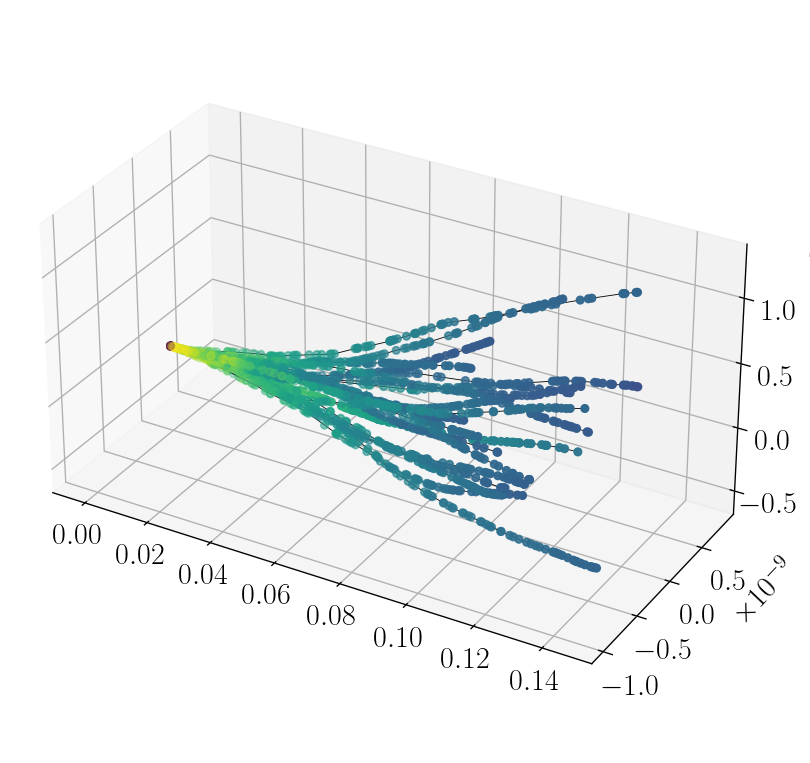

In [16]:
fig = plt.figure(figsize=(8,8))
axs = [fig.add_subplot(1, 1, 1, projection='3d')]
#axs[0].view_init(elev=25, azim=None, vertical_axis='z')
#view_init(elev=None, azim=None, roll=None, vertical_axis='z')

for pt in pt_list:
    axs[0].plot3D(pt.path[:,1], pt.path[:,2], pt.path[:,3], c='k', lw=0.5)
    axs[0].scatter3D(pt.path[:,1], pt.path[:,2], pt.path[:,3], c=pt.Ek_hist)
axs[0].set_box_aspect((1,1/2,1/2))
#axs[0].legend();

### 3.2 MC at multiple energies

In [17]:
xHII = 0.9999
rs = 1
Eek_s = np.logspace(3, 9, 30)

In [18]:
dists_old = []
dists_mc = []
dists_mc_x = []

for i, Eek in enumerate(tqdm(Eek_s)):
    
    ## old plot
    pt = Particle(m0=phys.me, name='electron')
    pt.init_with_Ek(Eek)
    
    rate = np.sum([prc.engloss_rate(pt, rs, xHII=xHII) for prc in process_list])
    dist = pt.beta * phys.c * 1/rate / Mpc
    
    dists_old.append(dist)
    
    ## MC
    pt = Particle(m0=phys.me, name='electron')
    pt.init_with_Ek(Eek)
    
    pt_list = simulate(Eek, rs, xHII=xHII, n_sim=100)
    dists_mc.append(np.array([pt.distance() for pt in pt_list]))
    dists_mc_x.append(np.array([pt.Ek for pt in pt_list]))

  0%|          | 0/30 [00:00<?, ?it/s]

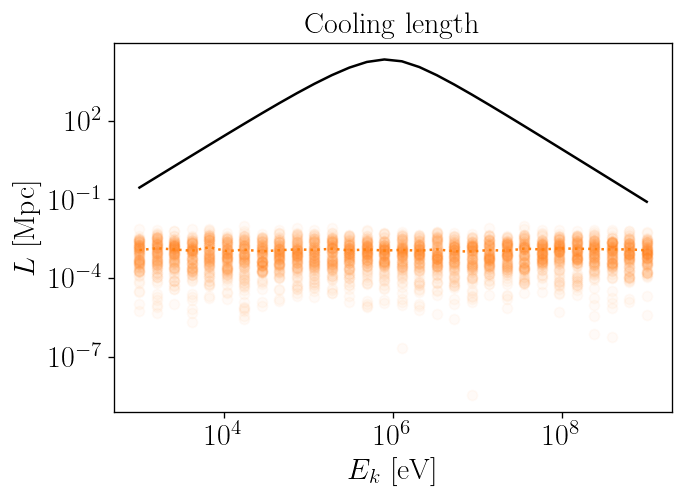

In [19]:
fig, ax = plt.subplots()

ax.plot(Eek_s, dists_old, color='k')
ax.scatter(np.array(dists_mc_x).flatten(), np.array(dists_mc).flatten(), c='C1', alpha=0.03)
ax.plot(Eek_s, [np.mean(dists) for dists in dists_mc], color='C1', linestyle=':')

ax.set(xscale='log', yscale='log')
ax.set(xlabel='$E_k$ [eV]', ylabel='$L$ [Mpc]', title='Cooling length');